Deep Learning Project

4/12/2024

In this assignment, a data set of tweets are analyzed and categorized into 'disaster' and 'non-disaster' categories using deep learning models. The learning algorithm is trained with just the tweets and required to identify which tweets are associated with 'disasters'.  It does so by looking at each word consecutively while also deriving meaning from sentences as a whole using short term and long term memory models.  After coming up with which tweets are diaster tweets, we can relate them back to the truth categories in order to determine its accuracy. 

The first part of the report is an exploratory data analysis.  First, the data is output and a few important notes are taken such as the number of features, what they are (text documents), and what the objective output might be (categories).  Then several natural language processing techniques are employed to consolidate the data and make it more organized using the natural language tool kit.  Afterwards, a longterm/shorterm memory model is employed to identify disaster tweets, which are then compared back to the original categories.  For simplicity, the categories are binary (disaster or non-disaster) as specified in the Kaggle competition, where the full problem statement can be found.

Data Source: https://www.kaggle.com/c/nlp-getting-started/data

Part 1: Exploratory Data Analysis

Part 2: LSTM Training and Results

Part 3: Conclusions


https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/

https://www.kaggle.com/code/raaavan/nlp-using-textvectorization

# __Part 1: Exploratory Data Analysis__

First we will load important libraries up front.  Please download the natural language tool kit if you don't have it, as it is important for conslidating the text data into a more usable format.

pip install --user -U nlkt

__Discussion__

Loaded libraries.  Not all ended up being needed.  I also could not figure out why no GPUs were available to tensorflow on my machine.  I have an Nvidia GeForce GTX 1660, CUDA is installed, my drivers are up to date, and I reinstalled tensorflow, anaconda, and several other packages...still unable to get tensorflow to see the GPU...

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, Flatten, Activation, Conv1D,MaxPooling1D
tf.config.list_physical_devices('GPU') 

[]

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


__Discussion__

The data is then read into pandas data frames.

In [3]:
# Read data into data frames with pandas.
train = pd.read_csv("train.csv")
solution = pd.read_csv("sample_submission.csv")
test = pd.read_csv("test.csv")

__Discussion__

Now lets look at what the first fifty rows of data in the train set.  We can see each row in the train data contains an Id, a location, and a huge a textual tweet, and a 'target', which we take to be its label (1 for disaster, 0 for non-disaster).  

Immediately, we can note that the location tells us little about the disaster or non-disaster qualities of the tweet and is blank for many entries.  Further, the keyword does not appear to be very useful, as they are all disaster related, aside from the few that are NAN.  It might be best to get rid of these excess columns.  We can also do this for the test file, as we will need to do so for submission purposes.


In [4]:
# Output top 5 rows of data.
print('Train head:')
display(train.head(50))

Train head:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
# Remove keyword and location columns.

train.drop(columns = ['keyword','location'], inplace = True)
test.drop(columns = ['keyword','location'], inplace = True)

print('Train and Test head:')
display(train.head())
display(test.head())

Train and Test head:


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


__Discussion__

Afterwards, lets look at the information summaries for the data.  We can see that the text is stored as objects, whereas the Id and target (labels) are stored as a int64.  We can also see that the train data contains 7613 rows and the test data contains 3263 rows.  In combination, all the data files reach about 130 kB in memory.

In [6]:
# Output data file information statistics.

print('Train Info:')
print(train.info())
print('\n')
print('Test Info:')
print(test.info())
print('\n')

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB
None


Test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB
None




__Discussion__

Looking at the sample solution file, we find that it contains ID's and targets (0 and 1 labels).

In [7]:
print('Submission head:')
display(solution.head())

Submission head:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


__Discussion__

Now we will look at what these tweets look like.  We can observe that some disaster tweets are quite clear.  In the first example, we have an individual who appears to be Islamic connecting likely impious or unjust deeds to what appears to be an earthquake.  Then asking for forgiveness from Allah.  Looking at another tweet, it's clear there has been no disaster as it discusses a positive attitude towards summer.  Then we have a really tough tweet to classify.  It talks of being 'ablaze' and also is set in a religious context, but is not about any disaster.  Instead it appears to just be talking about the individuals devotion to their god.  The model will clearly have to understand context.

In [8]:
print('Typical Disaster Tweet: \n')
print(train['text'][0])
print('\n')

print('Typical Non-Disaster Tweet: \n')
print(train['text'][17])
print('\n')

print('Tough Tweet to Classify: \n')
print(train['text'][39])
print('\n')

Typical Disaster Tweet: 

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


Typical Non-Disaster Tweet: 

Summer is lovely


Tough Tweet to Classify: 

Ablaze for you Lord :D




__Discussion__

Its important to know what we're dealing with, so lets plot the __histogram__ for number of occurrences of each category.  We can see that there are many more non-disaster tweets than disaster tweets.  This is probably reasonable as I doubt most tweets are disaster related.  That being said, I also would not say that Disaster tweets are under represented.

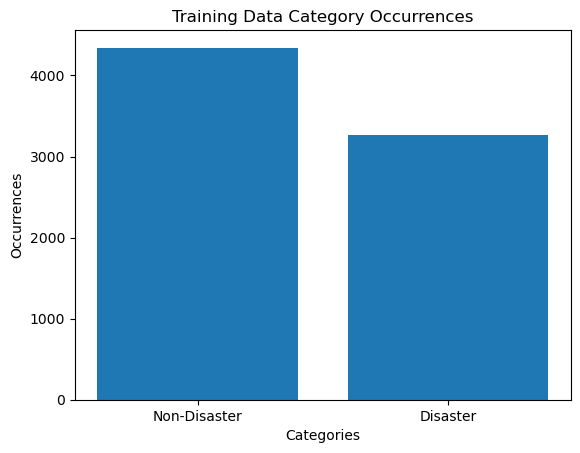

In [9]:
# Category occurrence analysis.
cat_occurrences = train['target'].value_counts()
plt.bar(['Non-Disaster','Disaster'], cat_occurrences)
plt.title('Training Data Category Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Categories')
plt.show()

__Discussion__

Observing textual word occurrences was much more challenging.  The textual word occurrences, as we can see in the first __histogram__ are numerous.  I couldn't make sense out of plotting all of them, so instead lets look at some collapsed __histograms__.  By outputting the top 10 most used words, we can see that most of these words are basically useless when it comes to actually determining which type of category the text documents are associated with.  However, these small words may help to add context to aid an LSTM in categorizing the tweets.  

If we take a look at most frequently used words 250 through 300, some should catch our eye.  As an example, the word 'Disaster' is the 258th most used word amidst the training text data.

C:\Users\14436\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


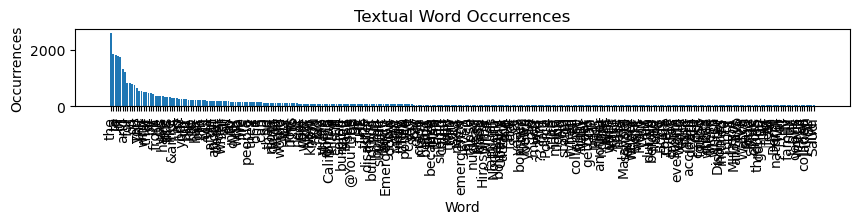

Total number of individual word counts: 31924


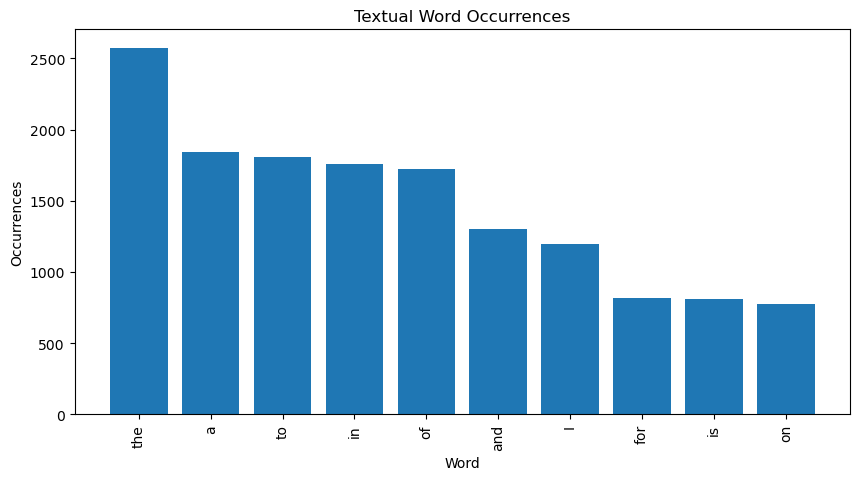

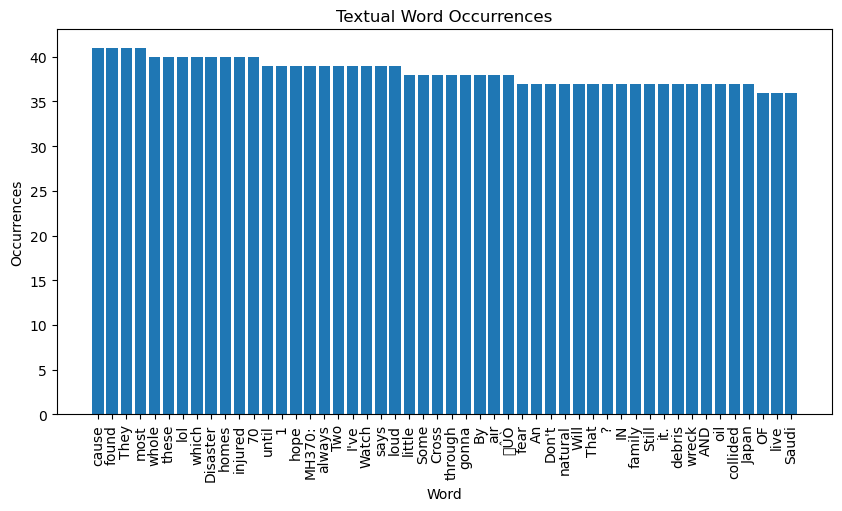

In [10]:
# Text occurrence analysis.
wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[0:300]
plt.figure(figsize=(10,1))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

print("Total number of individual word counts: " + str(len(wordCounts)))

reducedCount = wordCounts[0:10]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

reducedCount = wordCounts[250:300]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()



__Discussion__

However, if we plot the most used words 6950 through 7000, we can see a bunch of useless jargon. Further, these words are only used once.  

As a result of this analysis, the models chosen to be used in this project, and the frequency of words, I chose to keep the 'stop words' (simple frequently used words) in order to preserve context, but remove infrequently used words.  I did not believe these words would ultimately provide context nor help to classify textual exerpts.

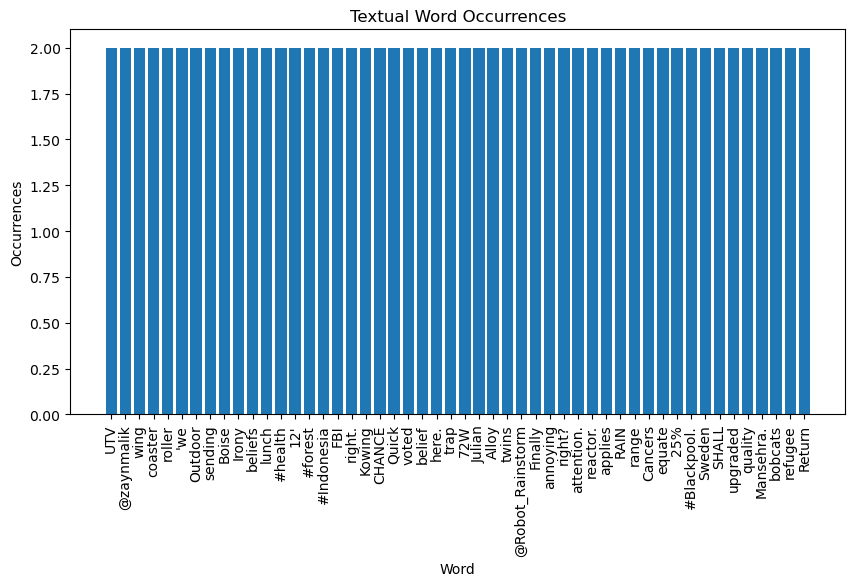

In [11]:
reducedCount = wordCounts[6950:7000]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

__Discussion__

Next, lets check to see if we have any text documents that have no length and see if most documents reside among similar numbers of word counts.  After plotting a histogram of the word counts, we can see that there aren't any with no word counts and they are all centered around the 2-30 word count region. There didn't appear to be any substantial outliers.

The median word count is: 15.0


C:\Users\14436\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


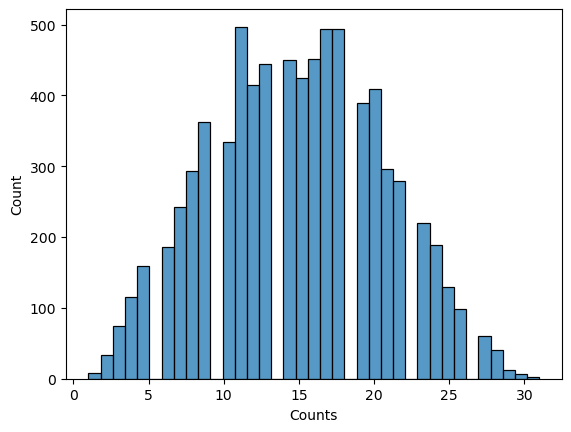

In [12]:
wordLists = train['text'].str.split()
textLengths = []

for text in wordLists:
    textLengths.append(len(text))

df1 = pd.DataFrame(data = textLengths)
df1.columns = ['Counts']

print('The median word count is: ' + str(df1['Counts'].median()))

plt1 = sns.histplot(data = df1, x = "Counts")

__Discussion__

Now, we will pass the text to __lower case__.  This will eliminate any ambiguity between capitalized words and lowercase words that are actually the same, but only different due to their case.  Then we will __not remove the 'stop' words__ as they are referred to in the natural language tool kit.  These words are redundant and don't provide any immediate information on the class or category of tweets, but could aid algorithms in understanding context.

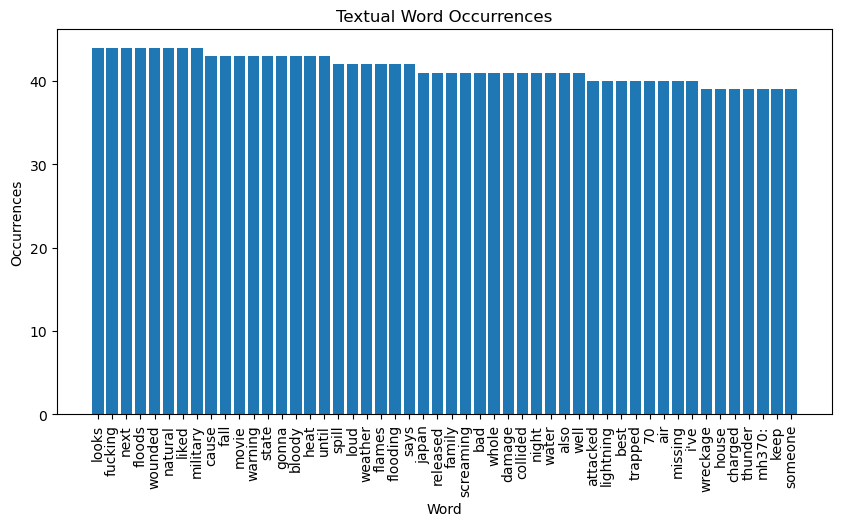

In [13]:
# Send text to lowercase.
train['text']=train['text'].str.lower()

wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[250:300]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

__Discussion__

Even so, its pretty clear that the word '.' is not going to be useful.  We need to __remove punctuation__.  So in order to do that we're going to replace r'[^\w\s]+' with ' '.  This I found as a method to use in conjunction with the pandas function replace, that replaces all punctuation with a space.  The space is important as we might have hyphons that string together multiple words that might provide context.  We can see this worked by plotting the word frequencies and observing that '.' has been removed.

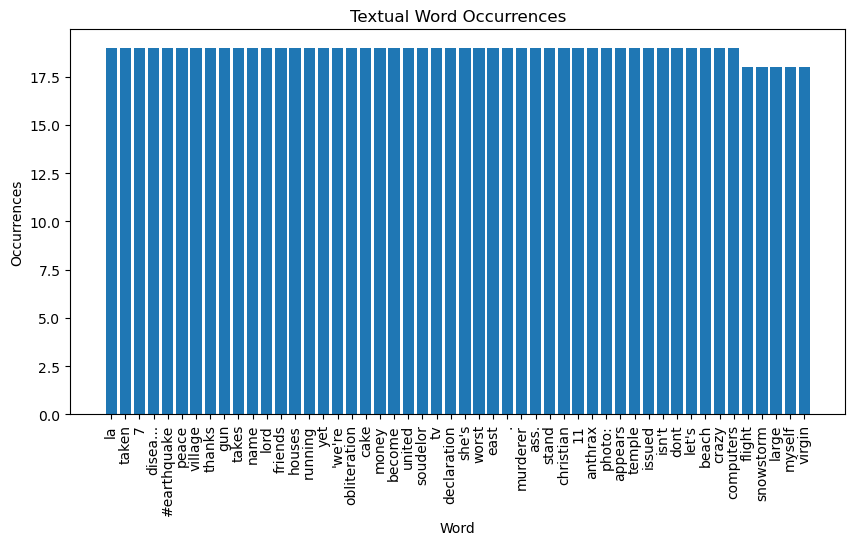

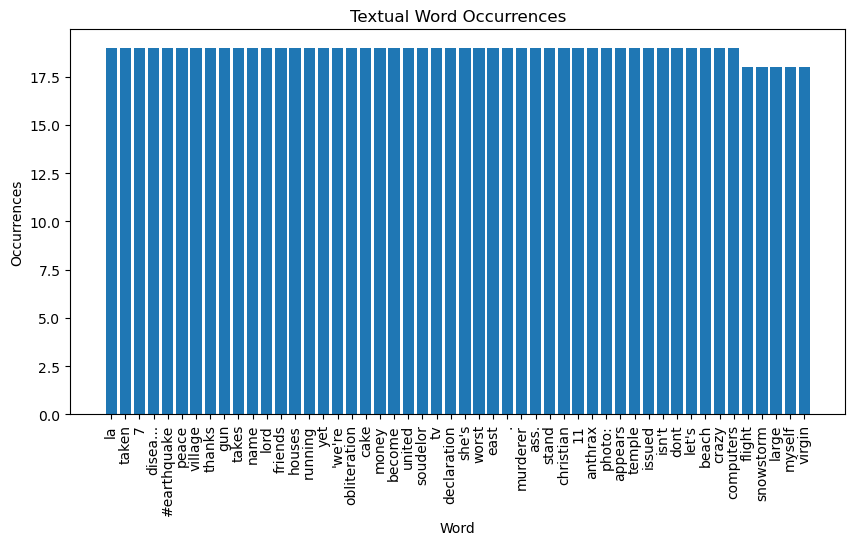

In [14]:
wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[800:850]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

# Remove the punctuation.
train['text'] = train['text'].str.replace(r'[^\w\s]+', '')

wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[800:850]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

__Discussion__

Now that punctuation has been removed and we've converted to lower case,  we will __remove infrequent words__ as discussed previously.

In [15]:
# Remove infrequent words.
wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()
dropWords = wordCounts.index[5000:]

warnings.filterwarnings("ignore")

for word in dropWords:
    ind = 0
    for lst in wordLists:
        for val in lst:
            if val == word:
                lst.remove(val)
                train['text'][ind] = " ".join(lst)
        ind += 1
        
warnings.filterwarnings("default")

wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

print(len(wordCounts))

5002


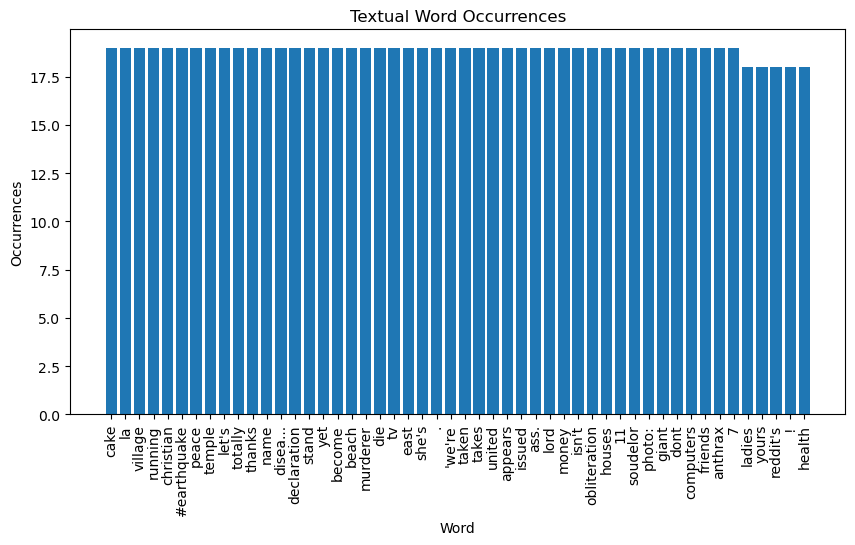

In [16]:
wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[800:850]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

__Discussion__

We will then __eliminate extra spaces__.  Extra spaces may distort the learning process by creating new words or relationships between words just by merely being in place. In general, we want one space between each token considered a word.

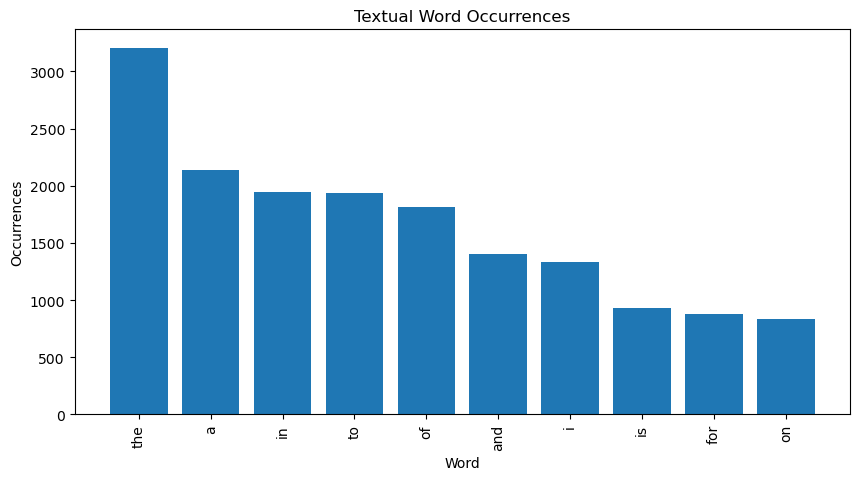

In [17]:
# Eliminate extra spaces.
train['text'] = train['text'].apply(lambda var: " ".join(var.split()))

wordLists = train['text'].str.split()
mappedWordsToRows = wordLists.explode()
wordCounts = mappedWordsToRows.value_counts()

reducedCount = wordCounts[0:10]
plt.figure(figsize=(10,5))
plt.bar(reducedCount.index, reducedCount)
plt.title('Textual Word Occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Word')
plt.xticks(rotation = 90)
plt.show()

__Discussion__

Based on the exploratory data analysis, an LSTM model to identify low level words (such as the word 'disaster') and high level contextual meanings.  The LSTM uses memory models in an attempt to feed fowards context and provide an alternative take on the purpose or intent of a tweet as opposed to an algorithm such as matrix factorization that ultimately looks at lower level features such as word frequencies. 

# __Part 2: LSTM Training and Results__

First, the train data is split into __training and validation__ data.  Getting the training/validation data into a format that could be read into the fit and predict functions was challenging, but eventually I found that the methods would take __batched tensor slices.__

After storing the data in the correct format, a __vectorization layer__ is created.  This layer takes words and converts them into integers.  This eases the computational burden during the training process.

After creating a vectorization layer, a __sequential model__ is created.  The sequential model contained a massive __embedding layer,__ which I found to greatly improved performance.  An __LSTM layer__ as discussed previously, and a __Dense layer__ before a final __output layer.__  The model was trained with __adaptive momentum,__ which was necessary due to the many points of local minima in the cost function.  Additionally, I found that __cross entropy__ actually worked better than binary cross entropy.  This may have been due to the sigmoid activation function in the final layer, which I found performed better than softmax, but would obviously require a threshold (say 0.5) that would need to be applied later to actually make binary predictions.

__Discussion__

The following code performs a __test train split.__  The test train split produced lists of strings instead of one list of sentences/tweets.  The code then generates one list of sentences/tweets for training and validation sets.  It then forces each entry to be cast as a string and reduces the dimension of the training and validation data.  Finally it casts the training and validation data as tensors and zips them into a data set with their respective training labels.  Finally, it batches the datasets.

In [19]:
# Test and train split.
X_train, X_val, y_train, y_val = train_test_split(train['text'].str.split(),train['target'],test_size=0.2,random_state=42)

# Store as list of tweets, not a list of lists of strings.
X_train_list = []
X_val_list = []
y_train_list = []
y_val_list = []

for entry in X_train:
    entry_list = ' '.join(entry)
    X_train_list.append([entry_list])
    
for entry in X_val:
    entry_list = ' '.join(entry)
    X_val_list.append([entry_list])
    
for entry in y_train:
    y_train_list.append(entry)
    
for entry in y_val:
    y_val_list.append(entry)

In [20]:
# Recast as strings, strip extra dimension.
X_train_fit = []

for entry in X_train_list:
    X_train_fit.append(str(entry[0]))

# Cast as tensors.
text_data = tf.data.Dataset.from_tensor_slices(X_train_fit)
labels = tf.data.Dataset.from_tensor_slices(y_train)

# Zip into dataset and batch.
dataset = tf.data.Dataset.zip((text_data, labels))
dataset = dataset.batch(10)

# Recast as strings, strip extra dimension.
X_val_fit = []

for entry in X_val_list:
    X_val_fit.append(str(entry[0]))

# Cast as tensors.
text_data_val = tf.data.Dataset.from_tensor_slices(X_val_fit)
labels_val = tf.data.Dataset.from_tensor_slices(y_val)

# Zip into dataset and batch.
dataset_val = tf.data.Dataset.zip((text_data_val, labels_val))
dataset_val = dataset_val.batch(10)

print(text_data)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


__Discussion__

Generate text __vectorization layer.__ This layer tockenizes the strings, making the training process easier.

In [21]:
# Generate text vectorization layer.
vectorize_layer = TextVectorization(max_tokens=15000,output_mode='int',output_sequence_length = 30,pad_to_max_tokens = True,
                                vocabulary = None,standardize = "lower_and_strip_punctuation",split = 'whitespace',ngrams = None)

vectorize_layer.adapt(text_data)

__Discussion__

Create __sequential model.__  Inputs are single sentences.  The text vectorization layer is then applied.  After which, a very large embedding layer is used to feed the LSTM layer.  The output of the LSTM layer is passed through a dense layer before reaching a single sigmoid activation layer. 

In [22]:

lstm_model = Sequential()
lstm_model.add(Input(shape = (1,), dtype = "string"))
lstm_model.add(vectorize_layer)
lstm_model.add(Embedding(input_dim = 15000, output_dim = 128,embeddings_initializer= 'uniform'))
lstm_model.add(LSTM(128))
lstm_model.add(Dense(32))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.build()
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 30)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 30, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,055,745 (7.84 MB)

 Trainable params: 2,055,745 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

__Discussion__

After compiling the model, it is then __fit against training data and validation data.__

In [23]:
lstm_model.compile(loss='crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(dataset, epochs=10, validation_data = dataset_val)

Epoch 1/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6621 - loss: 0.6142 - val_accuracy: 0.7538 - val_loss: 0.5461
Epoch 2/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8150 - loss: 0.4657 - val_accuracy: 0.7932 - val_loss: 0.4681
Epoch 3/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8550 - loss: 0.3719 - val_accuracy: 0.7912 - val_loss: 0.5409
Epoch 4/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8918 - loss: 0.3145 - val_accuracy: 0.7807 - val_loss: 0.6107
Epoch 5/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9108 - loss: 0.2594 - val_accuracy: 0.7768 - val_loss: 0.5532
Epoch 6/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9216 - loss: 0.2208 - val_accuracy: 0.7722 - val_loss: 0.7214
Epoch 7/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9330 - loss: 0.1870 - val_accuracy: 0.7643 - val_loss: 0.6028
Epoch 8/10
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9347 - loss: 0.1661 - 

# __Part 3: Conclusion__

I was very happy to see the LSTM based model achieve >90% training accuracy and almost 80% validation accuracy.  This was the first LSTM based model that I have created.  I noted the importance of having a large embedding layer, which I believe ultimately served the purpose of making the incoming data less noisy.

After finishing the training process, I noted that 2 epochs seemed to be best for training.  I looked at the training and validation accuracy curves to arrive at this conclusion.

I created a new final LSTM based model and retrained with two epochs.

Afterwards, I viewed performance against training data using a confusion matrix and noted that the algorithm struggled the most to label positive disaster labels as disasters, instead opting to label many as non-disasters.

Finally, I generated a submission file to submit to kaggle against the test data.

__Discussion__

We can observe the __training and validation accuracy curves__ evolving in a typical manner.  As more epochs are applied, the model overfits and validation error increases.  Eventually I took __2 epochs__ to be appropriate as it seemed to produce the best combination of high validation and high training accuracy. (Note that the values below may differ than the values above because the training process is stochastic and I may have rerun it).

Text(0, 0.5, 'Accuracy')

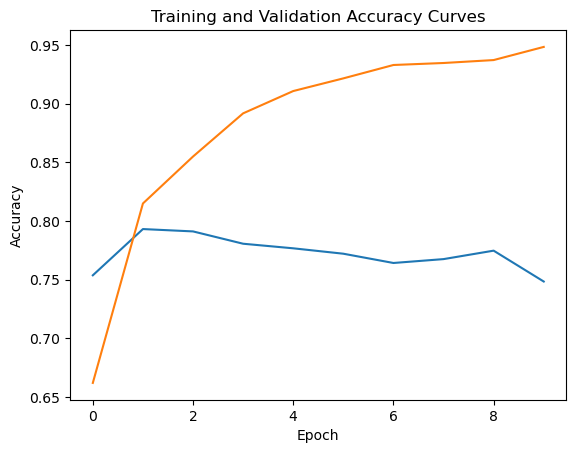

In [25]:
x = range(10)
y1 = [0.7538, 0.7932 ,0.7912, 0.7807,0.7768,0.7722,0.7643,0.7676,0.7748,0.7485]
y2 = [0.6621 , 0.8150 , 0.8550,0.8918, 0.9108 , 0.9216,0.9330 ,0.9347,0.9372 ,0.9484]

plt.plot(x,y1,y2)
plt.title("Training and Validation Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

__Discussion__

I then created a __final LSTM based model__ and retrained it with just two epochs.

In [26]:
lstm_model_final = Sequential()
lstm_model_final.add(Input(shape = (1,), dtype = "string"))
lstm_model_final.add(vectorize_layer)
lstm_model_final.add(Embedding(input_dim = 15000, output_dim = 128,embeddings_initializer= 'uniform'))
lstm_model_final.add(LSTM(128))
lstm_model_final.add(Dense(32))
lstm_model_final.add(Dense(1, activation='sigmoid'))
lstm_model_final.build()
lstm_model_final.summary()
lstm_model_final.compile(loss='crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model_final.fit(dataset, epochs=2, validation_data = dataset_val)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 30)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 30, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,055,745 (7.84 MB)

 Trainable params: 2,055,745 (7.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
609/609 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6492 - loss: 0.6277 - val_accuracy: 0.7840 - val_loss: 0.4957
Epoch 2/2
609/609 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8245 - loss: 0.4358 - val_accuracy: 0.7951 - val_loss: 0.4757


__Discussion__

Then the final model is used to run __predictions across training data.__  A __confusion matrix__ is used to display results. We can see that the algorithm is most frequently confused by disaster tweets that it ends up labeling as non-disaster tweets.

In [27]:
preds = lstm_model_final.predict(text_data.batch(1))
true = y_train

predictions = []
for val in preds:
    if val[0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

6090/6090 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


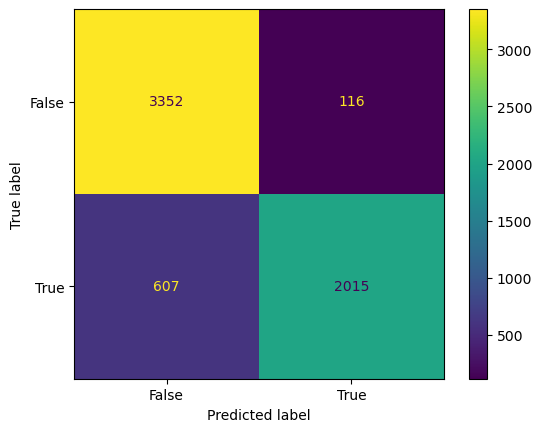

In [28]:
cm = confusion_matrix(true.values, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

__Discussion__

Finally, a __submission for Kaggle__ is generated across the test data.

In [29]:
X_test = test['text'].str.split()

X_test_list = []
X_id_list = []

for entry in X_test:
    entry_list = ' '.join(entry)
    X_test_list.append([entry_list])

X_test_fit = []

for entry in X_test_list:
    X_test_fit.append(str(entry[0]))
    
text_data_test = tf.data.Dataset.from_tensor_slices(X_test_fit)
preds = lstm_model_final.predict(text_data_test.batch(1))

3263/3263 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [30]:
target = []
for val in preds:
    if val > 0.5:
        target.append(1)
    else:
        target.append(0)
        
id = test['id']

data = {'id': id,'target': target}
df = pd.DataFrame(data)
df.to_csv('submission.csv')